In [ ]:
pip install Sastrawi nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [79]:
import pandas as pd
import string

#visualisasi
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

#modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix

In [80]:
data = pd.read_csv('dataBLT.csv')
data.head()

,judul,link,konten,halaman_sumber_pencarian
0,Wamendes: 80 Ribu Kopdes Merah Putih Launching...,https://news.detik.com/berita/d-7924631/wamend...,Wakil Menteri Desa dan Pembangunan Daerah Tert...,https://www.detik.com/search/searchall?query=b...
1,Subsidi BBM & Listrik Diganti ke BLT Tergantun...,https://finance.detik.com/energi/d-7622373/sub...,Pemerintah berencana mengeluarkan skema baru s...,https://www.detik.com/search/searchall?query=b...
2,"Kepedulian Walkot Vinanda ke Warga Kediri, Bag...",https://www.detik.com/jatim/berita/d-7890412/k...,Wali Kota Kediri Vinanda Prameswati menyampaik...,https://www.detik.com/search/searchall?query=b...
3,"Video: Subsidi BBM-Listrik Tak Tepat Sasaran, ...",https://20.detik.com/detikupdate/20241103-2411...,Pemerintah akan mengkaji skema subsidi bahan b...,https://www.detik.com/search/searchall?query=b...
4,Kata Bahlil Soal Opsi Alihkan Subsisi BBM-List...,https://www.detik.com/sumut/berita/d-7618281/k...,Menteri Energi dan Sumber Daya Mineral (ESDM) ...,https://www.detik.com/search/searchall?query=b...


In [81]:
# ambil kolom yg dibutuhkan

df = data.loc[:, ['konten']]

df.head()

,konten
0,Wakil Menteri Desa dan Pembangunan Daerah Tert...
1,Pemerintah berencana mengeluarkan skema baru s...
2,Wali Kota Kediri Vinanda Prameswati menyampaik...
3,Pemerintah akan mengkaji skema subsidi bahan b...
4,Menteri Energi dan Sumber Daya Mineral (ESDM) ...


In [82]:
# tokenization (Pecah teks menjadi unit-unit kata atau token.)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

NLTK (Natural Language Toolkit) adalah sebuah pustaka (library) yang sangat populer dalam bahasa pemrograman Python yang digunakan untuk berbagai tugas pemrosesan bahasa alami (Natural Language Processing/NLP).

In [83]:
# stopwords (Hapus kata-kata umum yang tidak memiliki makna sentimen signifikan (misalnya, "yang", "di", "dan", "adalah", "dengan", "ini", "itu").)
stop_words = stopwords.words('indonesian') + stopwords.words('english') + ["yg", "gak", "ngisi", "udah", "d", "sih", "nya", "srg", "utk", "byk", "gk", "ga", "aja", "tp", "udh"]

# Download the 'punkt_tab' resource
# Make sure to download the necessary NLTK data if you haven't already
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
except LookupError:
     nltk.download('punkt')



# tokenization and cleaning
# Convert all values to string before applying word_tokenize
df['konten'] = df['konten'].astype(str).apply(lambda x: [word.lower() for word in word_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)])

"Punkt" adalah salah satu modul atau paket data dalam NLTK yang berisi model pra-terlatih (pre-trained model) untuk tokenisasi kalimat (sentence tokenization).

In [84]:
# normalisasi teks
df['konten'] = df['konten'].apply(lambda x: ' '.join(x))

df.head()

,konten
0,wakil menteri desa pembangunan daerah tertingg...
1,pemerintah berencana mengeluarkan skema subsid...
2,wali kota kediri vinanda prameswati duka cita ...
3,pemerintah mengkaji skema subsidi bahan bakar ...
4,menteri energi sumber daya mineral esdm bahlil...


In [85]:
# stemming (Mengubah kata-kata ke bentuk dasarnya (misalnya, "memberantas", "pemberantasan" menjadi "berantas").)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stemmer = StemmerFactory().create_stemmer()
df['konten'] = df['konten'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df.head(5)

,konten
0,wakil menteri desa bangun daerah tinggal ahmad...
1,perintah rencana keluar skema subsidi energi m...
2,wali kota diri vinanda prameswati duka cita da...
3,perintah kaji skema subsidi bahan bakar minyak...
4,menteri energi sumber daya mineral esdm bahlil...


In [86]:
!pip install vaderSentiment

In [87]:
# labelling
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

additional_lexicon_id = {
    'membantu': 0.7,
    'meringankan': 0.6,
    'tepat sasaran': 0.8,
    'sukses': 0.7,
    'apresiasi': 0.5,
    'menyambut baik': 0.6,
    'kendala': -0.6,
    'masalah': -0.5,
    'tidak tepat sasaran': -0.8,
    'penyelewengan': -0.9,
    'korupsi': -1.0, # Mungkin ada kata spesifik seperti ini
    'keluhan': -0.4,
    'terlambat': -0.3,
    'dipotong': -0.7, # Lebih spesifik untuk BLT
    'tidak adil': -0.7,
    'pemerintah': 0, # Netral
    'menyalurkan': 0.1, # Agak netral atau sedikit positif
    'program': 0,
    'anggaran': 0,
    'data': 0,
    'penerima': 0,
    # ... tambahkan kata-kata dari leksikon Anda sebelumnya jika masih relevan
    # ... dan kata-kata baru yang Anda temukan
    'kecewa': -0.4, # Dari leksikon Anda sebelumnya
    'rugi': -1,     # Dari leksikon Anda sebelumnya
    'bagus': 0.5,   # Dari leksikon Anda sebelumnya
    'mantap': 1,
}

analyzer.lexicon.update(additional_lexicon_id)

df['sentimen'] = df['konten'].apply(lambda x: 'Positif' if analyzer.polarity_scores(x)['compound'] > 0 else ('Negatif' if analyzer.polarity_scores(x)['compound'] < 0 else 'Netral'))

df

,konten,sentimen
0,wakil menteri desa bangun daerah tinggal ahmad...,Positif
1,perintah rencana keluar skema subsidi energi m...,Negatif
2,wali kota diri vinanda prameswati duka cita da...,Negatif
3,perintah kaji skema subsidi bahan bakar minyak...,Netral
4,menteri energi sumber daya mineral esdm bahlil...,Positif
...,...,...
95,keluarga buruh tani tembakau kabupaten blora t...,Netral
96,presiden joko widodo jokowi tolak manado sulaw...,Netral
97,komisi dprd klaten jelas pemkab klaten kait te...,Negatif
98,perintah kota pemkot pasuruan salur bantu lang...,Netral


In [88]:
# TF-IDF (mengukur seberapa penting sebuah kata (term) dalam sebuah dokumen tertentu yang merupakan bagian dari sekumpulan dokumen)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['konten'])

In [89]:
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

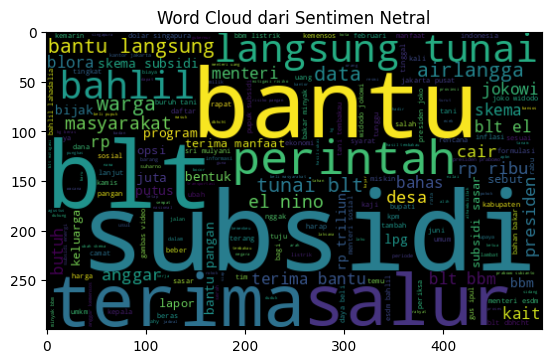

In [90]:
df_netral = df[df['sentimen'] == 'Netral']
all_words_netral = ' '.join([twts for twts in df_netral['konten']])
wordcloud_netral = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_netral)

plt.imshow(wordcloud_netral, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Netral')
plt.show()

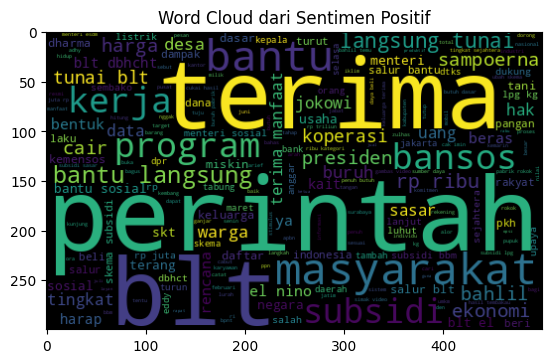

In [91]:
df_positif = df[df['sentimen'] == 'Positif']
all_words_positif = ' '.join([twts for twts in df_positif['konten']])
wordcloud_positif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_positif)

plt.imshow(wordcloud_positif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Positif')
plt.show()

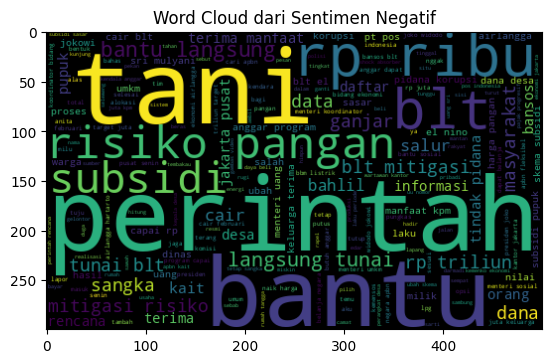

In [92]:
df_negatif = df[df['sentimen'] == 'Negatif']
all_words_negatif = ' '.join([twts for twts in df_negatif['konten']])
wordcloud_negatif = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(all_words_negatif)

plt.imshow(wordcloud_negatif, interpolation="bilinear")
# plt.axis('off')
plt.title('Word Cloud dari Sentimen Negatif')
plt.show()

In [93]:
temp = df.groupby('sentimen').count()['konten'].reset_index().sort_values(by='konten',ascending=False)
temp.style.background_gradient(cmap='inferno_r')

,sentimen,konten
1,Netral,47
0,Negatif,32
2,Positif,21


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='sentimen', ylabel='count'>

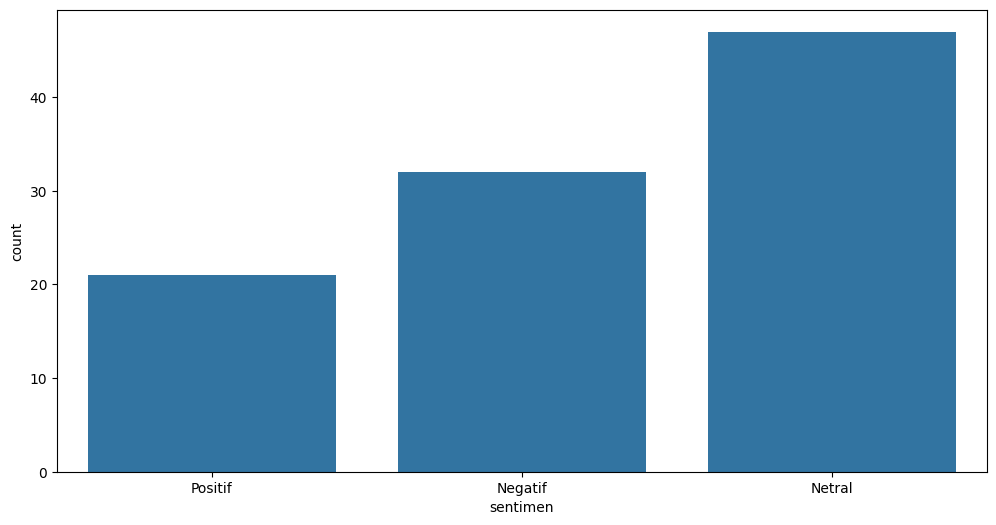

In [95]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentimen',data=df)

In [96]:
!pip install palettable
from palettable.colorbrewer.qualitative import Pastel1_7

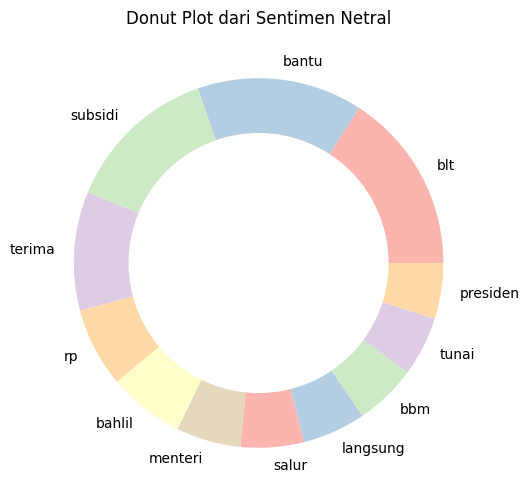

In [98]:
unique_netral_words = df_netral['konten'].str.split(expand=True).stack().value_counts().reset_index()
unique_netral_words.columns = ['words', 'count']
top_20_words = unique_netral_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen Netral')
plt.show()

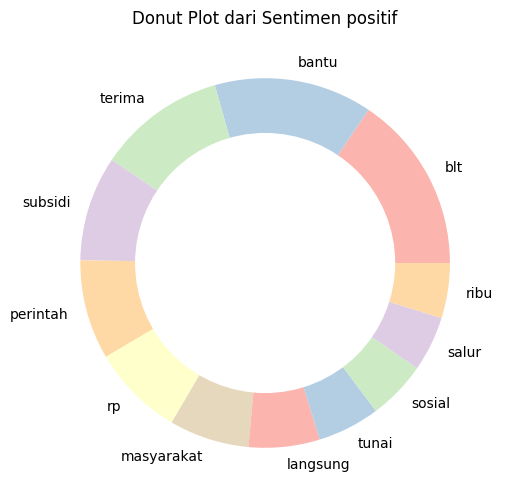

In [100]:
unique_positif_words = df_positif['konten'].str.split(expand=True).stack().value_counts().reset_index()
unique_positif_words.columns = ['words', 'count']
top_20_words = unique_positif_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen positif')
plt.show()

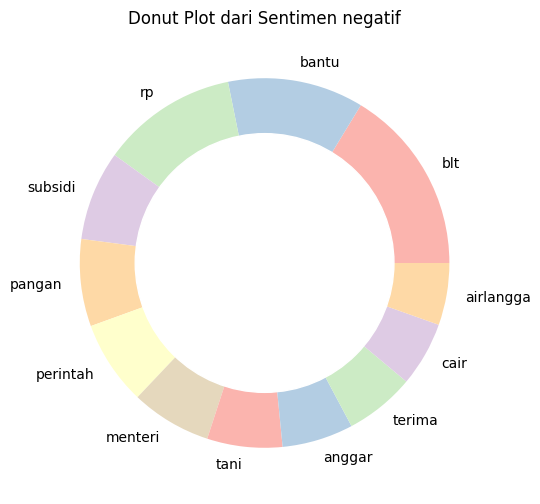

In [101]:
unique_negatif_words = df_negatif['konten'].str.split(expand=True).stack().value_counts().reset_index()
unique_negatif_words.columns = ['words', 'count']
top_20_words = unique_negatif_words.head(12)
plt.figure(figsize=(12, 6))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(top_20_words['count'], labels=top_20_words['words'], colors=Pastel1_7.hex_colors)
plt.gca().add_artist(my_circle)
plt.title('Donut Plot dari Sentimen negatif')
plt.show()

In [102]:
# splitting (mengevaluasi kinerja model machine learning Anda secara objektif pada data yang belum pernah dilihat sebelumnya)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentimen'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((80, 1990), (20, 1990))

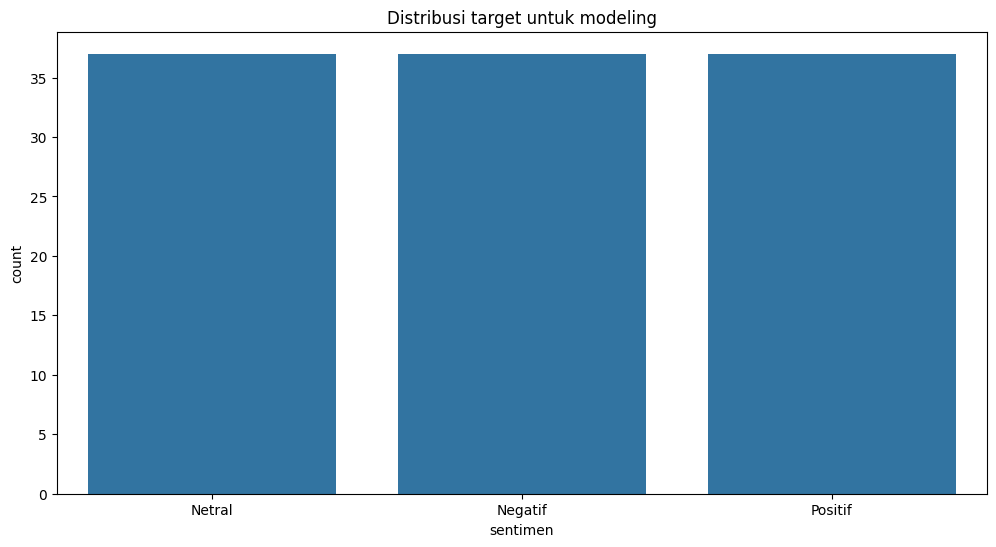

In [103]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(12, 6))
sns.countplot(x=y_train)
plt.title('Distribusi target untuk modeling')
plt.show()

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [105]:
# init parameters
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4]}

In [106]:
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='accuracy')

In [107]:
# print best param
print("\nBest Parameters for Random Forest:", rf_model.best_params_)


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [108]:
# evaluasi model
from sklearn.metrics import classification_report

y_pred_rf = rf_model.best_estimator_.predict(X_test)

print("\n\nClassification Report for Random Forest (Tuned):")
print(classification_report(y_test, y_pred_rf))



Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

     Negatif       0.67      0.80      0.73         5
      Netral       0.69      0.90      0.78        10
     Positif       1.00      0.20      0.33         5

    accuracy                           0.70        20
   macro avg       0.79      0.63      0.61        20
weighted avg       0.76      0.70      0.66        20



- Precision: 0.67 (67%) => Dari semua yang diprediksi model sebagai "Negatif", 67% di antaranya memang benar-benar "Negatif". Sisanya (33%) adalah prediksi "Negatif" yang salah (sebenarnya mungkin Netral atau Positif).

- Recall: 0.80 (80%) => Dari semua data yang sebenarnya "Negatif", model Anda berhasil mengidentifikasi 80% di antaranya. Sisanya (20%) terlewatkan (salah diklasifikasikan sebagai Netral atau Positif).

- F1-score: 0.73 => Keseimbangan yang cukup baik antara presisi dan recall untuk kelas Negatif.

- Support: 5 => Ada 5 sampel "Negatif" dalam data pengujian


- Precision: 0.69 (69%) => Cukup baik. Ketika model memprediksi "Netral", sekitar 69% akurat.
- Recall: 0.90 (90%) => Sangat baik! Model berhasil menemukan 90% dari semua data yang memang "Netral".
- F1-score: 0.78 => Skor F1 yang baik, menunjukkan performa yang solid untuk kelas Netral.
- Support: 10 => Ada 10 sampel "Netral" (kelas dengan sampel terbanyak di data uji).

- Precision: 1.00 (100%) => Luar biasa! Setiap kali model Anda memprediksi sesuatu sebagai "Positif", prediksinya selalu benar. Tidak ada prediksi "Positif" yang salah.
- Recall: 0.20 (20%) => SANGAT RENDAH! Ini adalah masalah utama. Dari semua data yang sebenarnya "Positif", model Anda hanya berhasil mengenali 20% saja. Artinya, 80% data "Positif" lainnya salah diklasifikasikan oleh model (kemungkinan besar sebagai Netral atau Negatif).
- F1-score: 0.33 => Sangat rendah, ini ditarik turun oleh nilai Recall yang juga sangat rendah, meskipun Precision-nya sempurna.
- Support: 5 => Ada 5 sampel "Positif" dalam data pengujian.